Import 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from numpy.random import randint, randn, shuffle
from time import time
from scipy.stats import norm
from sklearn.utils import resample

Define Franke function

In [2]:
def FrankeFunction(x,y):
	term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
	term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
	term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
	term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
	return term1 + term2 + term3 + term4

Plotting variables

In [3]:
figwidth = 10
figheigth = 10
fontsize = 18
seed = 231243

Create design matrix for for two dimensions

In [4]:
def create_X(x, y, n):
    #n is the order of the polynomial
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
    N = len(x)
    p = int((n+1)*(n+2)/2)  #Number of elements in beta, 
    X = np.ones((N, p))
    
    for i in range(1,n+1):
        q = int(i*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    
    return X

Define R2 score function

In [5]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

Define Mean Squared Error (MSE) function

In [6]:
def MSE(y_data,y_model):
    return np.sum((y_data-y_model)**2)/np.size(y_model)

OLS regression

In [7]:
def ols(X_test, X_train, z_test, z_train):
    """
    Perform OLS regression
    return z_predict and z_tilde
    """
    beta_ols = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
    z_tilde = X_train @ beta_ols
    z_predict = X_test @ beta_ols
    
    return z_predict, z_tilde, beta_ols

Ridge regression

In [8]:
def ridge(X_test, X_train, z_test, z_train, _lambda):
    """
    Perform Ridge regression
    return z_predict and z_tilde and the resulting beta values
    """
    I = np.eye(X_train.shape[1])
    beta_ridge = np.linalg.pinv(X_train.T @ X_train + _lambda*I) @ X_train.T @ z_train #beta from Ridge-regression
    z_tilde = X_train @ beta_ridge
    z_predict = X_test @ beta_ridge
    
    return z_predict, z_tilde, beta_ridge

Lasso regression

In [9]:
def lasso(X_test, X_train, z_test, z_train, _lambda, tol):
    """
    Perform Lasso-regression using SciKit learn
    return z_predict, z_tilde and the resulting beta values
    """
    np.random.seed(seed)
    clf_lasso = skl.Lasso(alpha=_lambda, fit_intercept=False, normalize=True, tol=tol, random_state=11).fit(X_train, z_train)
    beta_lasso = clf_lasso.coef_
            
    z_tilde = X_train @ beta_lasso
    z_predict = X_test @ beta_lasso
    
    return z_predict, z_tilde, beta_lasso

Bootstrap function

In [10]:
def resample_bootstrap(method, n_bootstraps, X_train, X_test, z_train, z_test, _lambda=1, tol = 0.04):
    """
    Perform bootstrap resampling for n_bootstraps
    Return the mean bootstrap MSE for the given complexity and the predicted data
    Need to choose method=ols, method=ridge or method=lasso
    tol only for lasso regression
    """
    
    MSE_test_values = np.zeros(n_bootstraps)
    z_predict = np.empty((X_test.shape[0], n_bootstraps))
    I = np.eye(X_train.shape[1] + X_test.shape[1])
    
    for j in range(n_bootstraps):
        X_train_resample, z_train_resample = resample(X_train, z_train, replace=True)
        if method==ols:
            z_predict[:, j], z_tilde_ols, beta_boot = ols(X_test, X_train_resample, z_test, z_train_resample)
        if method==ridge:
            z_predict[:, j], z_tilde, beta_boot = ridge(X_test, X_train_resample, z_test, z_train_resample, _lambda)
        if method==lasso:
            z_predict[:, j], z_tilde, beta_boot = lasso(X_test, X_train_resample, z_test, z_train_resample, _lambda, tol=tol)
            
        MSE_test_values[j] = MSE(z_test, z_predict[:, j])
    
    MSE_test = np.mean(MSE_test_values)
    
    return MSE_test, z_predict, beta_boot


K-fold cross validation function

In [11]:
def kfold_crossValidation(method, X, z, k_folds, _lambda=1, tol=0.04):
    
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(z)
    z_split = np.array_split(z, k_folds)
    X_split = np.array_split(X, k_folds)
    MSE_test_values = np.zeros(k_folds)

    for k in range(k_folds):
        z_test = z_split[k]
        z_train = np.concatenate(np.delete(z_split, k, 0))

        X_test = X_split[k] #picks out the kth matrix from X
        X_train = np.concatenate(np.delete(X_split, k, 0)) #deletes the kth matrix, and leaves the rest
            
        X_train, X_test = scaleData(X_train, X_test)
        
        if method==ols:
            z_predict, z_tilde, beta_kfold = ols(X_test, X_train, z_test, z_train)
        if method==ridge:
            z_predict, z_tilde, beta_kfold = ridge(X_test, X_train, z_test, z_train, _lambda)
        if method==lasso:
            z_predict, z_tilde, beta_kfold = lasso(X_test, X_train, z_test, z_train, _lambda, tol=tol)
            
        MSE_test_values[k] = MSE(z_test,z_predict)
            
    MSE_test = np.mean(MSE_test_values)
    return MSE_test, z_predict, beta_kfold

Generating Data

In [12]:
def generateData(n, polydegree, noise_factor):
    """
    n = size opf x and y
    degree = polynomial d
    noise_factor = self explanatory
    """
    np.random.seed(seed+seed)
    noise = noise_factor*np.random.randn(n)
    x = np.random.uniform(0,1,n)
    y = np.random.uniform(0,1,n)
    z = FrankeFunction(x,y) + noise
    X = create_X(x, y, polydegree)
    return z, X

Scale data

In [13]:
def scaleData(X_train, X_test):
    X_mean = np.mean(X_train)
    X_std = np.std(X_train)
    X_train_scaled = (X_train - X_mean)/X_std
    X_test_scaled = (X_test - X_mean)/X_std
    return X_train_scaled, X_test_scaled

Perform the Ordinary Least Square (OLS) method and print the MSE and R2 results

In [14]:
z, X = generateData(n=1000, polydegree=9, noise_factor=0.1)
np.random.seed(seed)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, shuffle=True, random_state=11)

X_train, X_test = scaleData(X_train, X_test)

beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train

z_tilde = X_train @ beta
z_predict = X_test @ beta

print("Training R2")
print(R2(z_train,z_tilde))
print(' ')
print("Training MSE")
print(MSE(z_train,z_tilde))
print(' ')
print("Test R2")
print(R2(z_test,z_predict))
print(' ')
print("Test MSE")
print(MSE(z_test,z_predict))

Training R2
0.8896771558743709
 
Training MSE
0.009612776672372782
 
Test R2
0.8767918439412131
 
Test MSE
0.010333538732101456


We see that the MSE from the test data, is higher than the training data. This is for higher complexity. For lower complexity, we see that they are more equal.

Study the bias-variance trade-off by plotting the MSE for increasing model complexity (i.e. the number of polynomials)

Implement bootstrap resampling

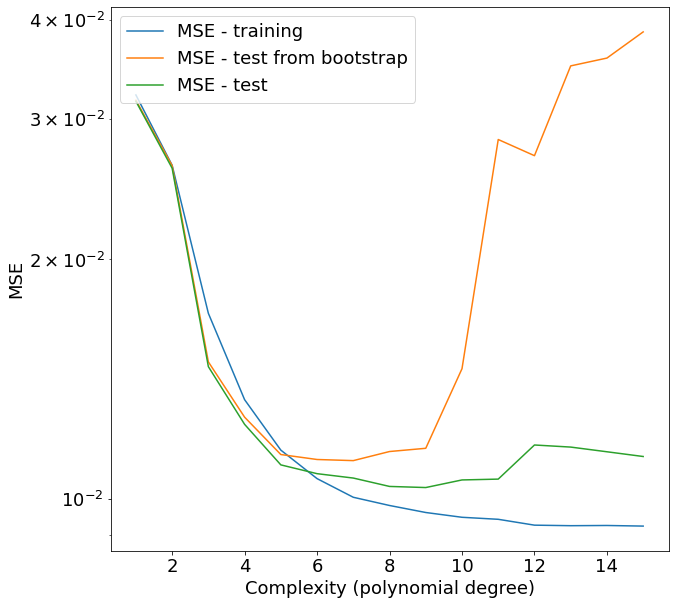

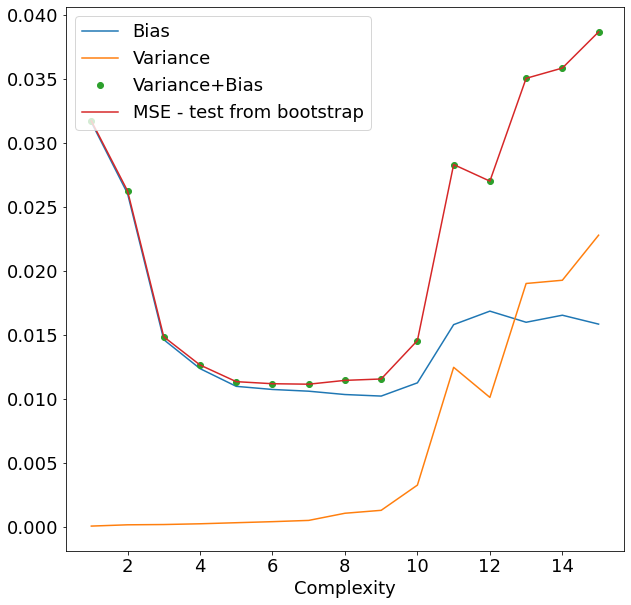

In [76]:
max_degree = 15
degree = np.linspace(1, max_degree, max_degree)
MSE_test = np.zeros(max_degree)
MSE_train = np.zeros(max_degree)
MSE_test_bootstrap = np.zeros(max_degree)

bias = np.zeros(max_degree)
variance = np.zeros(max_degree)
error = np.zeros(max_degree)

for i in range(max_degree):
    z, X = generateData(n = 1000, polydegree = int(degree[i]), noise_factor = 0.1)
    
    np.random.seed(seed)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, shuffle=True, random_state=11)

    X_train, X_test = scaleData(X_train, X_test)
    z_predict, z_tilde, beta_OLS = ols(X_test, X_train, z_test, z_train)
    
    MSE_train[i] = MSE(z_train,z_tilde)
    MSE_test[i] = MSE(z_test,z_predict)
    
    #Perform OLS with bootstrap resampling
    n_bootstraps = 100
    MSE_test_bootstrap[i], z_predicted_bootstrap, beta_bootstrap = resample_bootstrap(ols, n_bootstraps, X_train, X_test, z_train, z_test)
    
    
    bias[i] = np.mean( (z_test - np.mean(z_predicted_bootstrap, axis=1))**2 )
    variance[i] = np.mean(np.var(z_predicted_bootstrap, axis=1))
    
plt.figure(figsize=(figwidth, figheigth))
plt.tick_params(axis='both', which='both', labelsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.xlabel('Complexity (polynomial degree)', fontsize=fontsize)
plt.plot(degree, MSE_train, label='MSE - training') 
plt.plot(degree, MSE_test_bootstrap, label='MSE - test from bootstrap') 
plt.plot(degree, MSE_test, label='MSE - test')
plt.yscale('log')
plt.legend(fontsize=fontsize, loc='upper left')
plt.savefig('figures/mse_test_training_bootstrap')
plt.show()


plt.figure(figsize=(figwidth, figheigth))
plt.tick_params(axis='both', which='both', labelsize=fontsize)
plt.xlabel('Complexity', fontsize=fontsize)
plt.plot(degree, bias, label='Bias')
plt.plot(degree, variance, label='Variance')
plt.plot(degree, variance+bias, 'o', label='Variance+Bias')
plt.plot(degree, MSE_test_bootstrap, label='MSE - test from bootstrap')
#plt.yscale('log')
plt.legend(fontsize=fontsize, loc='upper left')
plt.savefig('figures/bias_variande_tradeoff_bootstrap')
plt.show()

Implement k-fold cross validation

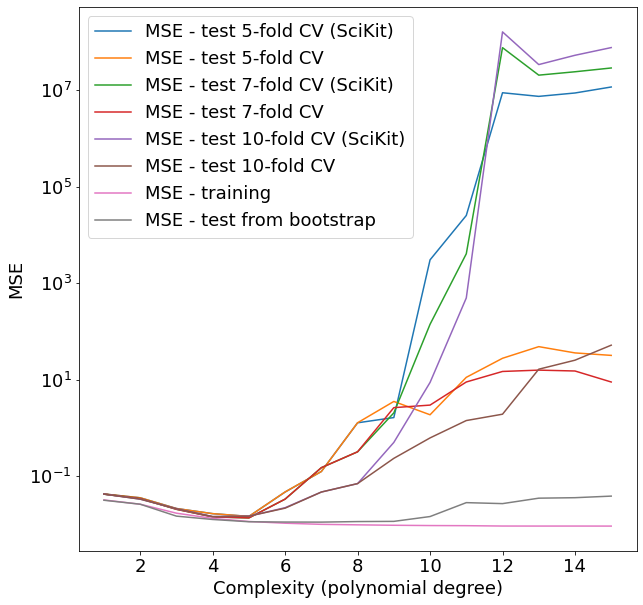

In [77]:
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) #not exactly sure if i need this...

folds = np.array([5,7,10], dtype=int) #number of folds

degree = np.linspace(1, max_degree, max_degree)

plt.figure(figsize=(figwidth, figheigth))

for k_folds in folds:
    
    MSE_test_kfold = np.zeros(max_degree)
    MSE_test_kfold_scikit = np.zeros(max_degree)
    
    for i in range(max_degree):
        
        z, X = generateData(n = 100, polydegree = int(degree[i]), noise_factor = 0.1)
        
        MSE_test_kfold[i] = kfold_crossValidation(ols, X, z, k_folds)[0]
        
        #k-fold cross validation using SciKit    
        kfold_scikit = KFold(n_splits = k_folds)
        MSE_test_kfold_values_scikit = np.zeros(k_folds)
        
        k=0
        for train_inds, test_inds in kfold_scikit.split(X):
            
            X_train = X[train_inds]
            z_train = z[train_inds]

            X_test = X[test_inds]
            z_test = z[test_inds]
            
            X_train, X_test = scaleData(X_train, X_test)
            
            model = LinearRegression(fit_intercept=True).fit(X_train, z_train)
            z_predict = model.predict(X_test)
            z_tilde = model.predict(X_train)
            MSE_test_kfold_values_scikit[k] = MSE(z_test,z_predict)
            k+=1
        
        MSE_test_kfold_scikit[i] = np.mean(MSE_test_kfold_values_scikit)

    plt.plot(degree, MSE_test_kfold_scikit, label='MSE - test %.i-fold CV (SciKit)'%k_folds)   
    plt.plot(degree, MSE_test_kfold, label='MSE - test %.i-fold CV'%k_folds)


plt.ylabel('MSE', fontsize=fontsize)
plt.xlabel('Complexity (polynomial degree)', fontsize=fontsize)
plt.plot(degree, MSE_train, label='MSE - training') 
plt.plot(degree, MSE_test_bootstrap, label='MSE - test from bootstrap')
#plt.plot(degree, MSE_test, label='MSE - test')
plt.yscale('log')
plt.tick_params(axis='both', which='both', labelsize=18)
plt.legend(fontsize=18, loc='upper left')
plt.savefig('figures/mse_test_kfold_bootstrap')
plt.show()

Implement Ridge Regression and Lasso on Franke data

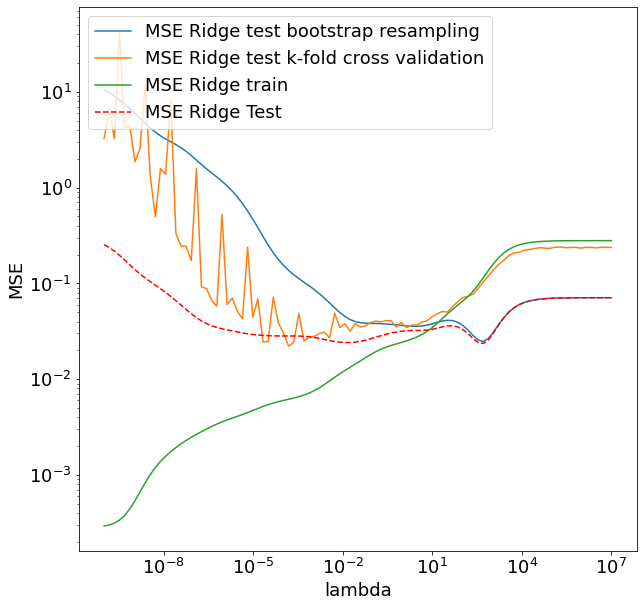

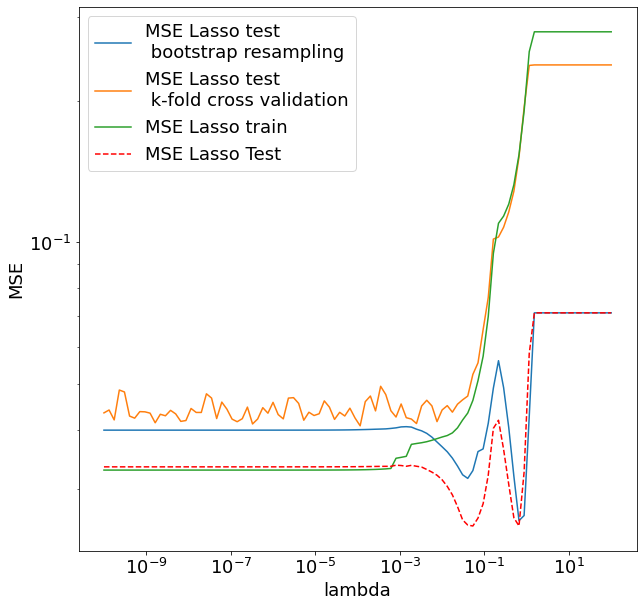

In [78]:
p = 7 #polynomial degree
nlambdas = 100
lambdas_ridge = np.logspace(-10, 7, nlambdas)
lambdas_lasso = np.logspace(-10, 2, nlambdas)

MSE_test_ridge = np.zeros(nlambdas)
MSE_train_ridge = np.zeros(nlambdas)
MSE_test_ridge_bootstrap = np.zeros(nlambdas)
MSE_test_ridge_kfold = np.zeros(nlambdas)

MSE_test_lasso = np.zeros(nlambdas)
MSE_train_lasso = np.zeros(nlambdas)
MSE_test_lasso_bootstrap = np.zeros(nlambdas)
MSE_test_lasso_kfold = np.zeros(nlambdas)


        
z, X = generateData(n = 50, polydegree = p, noise_factor = 0.1)
 #split data
np.random.seed(seed)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, shuffle=True, random_state=11)

X_train, X_test = scaleData(X_train, X_test)

for i in range(nlambdas):
    _lambda = lambdas_ridge[i]
        
    #perform Ridge regression with bootstrap resampling and k-fold cross validation
    z_predict, z_tilde, beta_ridge = ridge(X_test, X_train, z_test, z_train, _lambda)

    MSE_train_ridge[i] = MSE(z_train, z_tilde)
    MSE_test_ridge[i] = MSE(z_test, z_predict)

    MSE_test_ridge_bootstrap[i] = resample_bootstrap(ridge, 100, X_train, X_test, z_train, z_test, _lambda = _lambda)[0]

    MSE_test_ridge_kfold[i] = kfold_crossValidation(ridge, X, z, k_folds=7, _lambda=_lambda)[0]

    _lambda = lambdas_lasso[i]
    #perform Lasso regression with bootstrap resampling and k-fold cross validation

    z_predict, z_tilde, beta_lasso = lasso(X_test, X_train, z_test, z_train, _lambda, tol=0.08)

    MSE_train_lasso[i] = MSE(z_train, z_tilde)
    MSE_test_lasso[i] = MSE(z_test, z_predict)

    MSE_test_lasso_bootstrap[i] = resample_bootstrap(lasso, 100, X_train, X_test, z_train, z_test, _lambda = _lambda, tol = 0.08)[0]

    MSE_test_lasso_kfold[i] = kfold_crossValidation(lasso, X, z, k_folds=10, _lambda=_lambda, tol = 0.08)[0]
    
    
plt.figure(figsize=(figwidth, figheigth))
plt.tick_params(axis='both', which='both', labelsize=fontsize)
plt.plot(lambdas_ridge, MSE_test_ridge_bootstrap, label = 'MSE Ridge test bootstrap resampling')
plt.plot(lambdas_ridge, MSE_test_ridge_kfold, label = 'MSE Ridge test k-fold cross validation')
plt.plot(lambdas_ridge, MSE_train_ridge, label = 'MSE Ridge train')
plt.plot(lambdas_ridge, MSE_test_ridge, 'r--', label = 'MSE Ridge Test')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lambda', fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.legend(fontsize=fontsize, loc='upper left')
plt.show()


plt.figure(figsize=(figwidth, figheigth))
plt.tick_params(axis='both', which='both', labelsize=fontsize)
plt.plot(lambdas_lasso, MSE_test_lasso_bootstrap, label = 'MSE Lasso test \n bootstrap resampling')
plt.plot(lambdas_lasso, MSE_test_lasso_kfold, label = 'MSE Lasso test \n k-fold cross validation')
plt.plot(lambdas_lasso, MSE_train_lasso, label = 'MSE Lasso train')
plt.plot(lambdas_lasso, MSE_test_lasso, 'r--', label = 'MSE Lasso Test')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lambda', fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.legend(fontsize=fontsize, loc='upper left')
plt.show()

Prepare real data for analysis

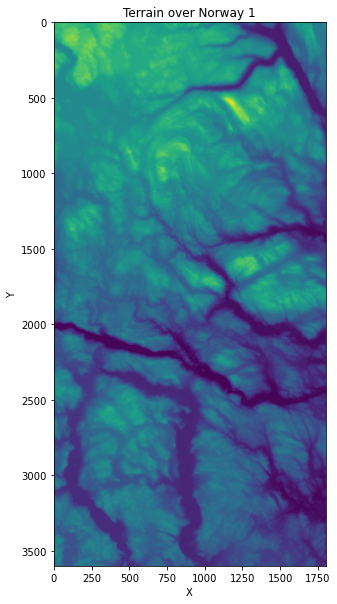

In [81]:
# Load the terrain
terrain_file = imread('Datafiles/SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure(figsize=(figwidth, figheigth))
plt.title('Terrain over Norway 1')
plt.imshow(terrain_file)#, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


terrain_file = imread('Datafiles/SRTM_data_Norway_1.tif')
x = np.linspace(0,1,terrain_file.shape[1])
y = np.linspace(0,1,terrain_file.shape[0])
x_grid, y_grid = np.meshgrid(x,y)
z_data = terrain_file

##Cutting
x_values = x_grid[1::300, 1::150]
y_values = y_grid[1::300, 1::150]
z_values = z_data[1::300, 1::150]

z = z_values.ravel()

Real data k-fold analysis

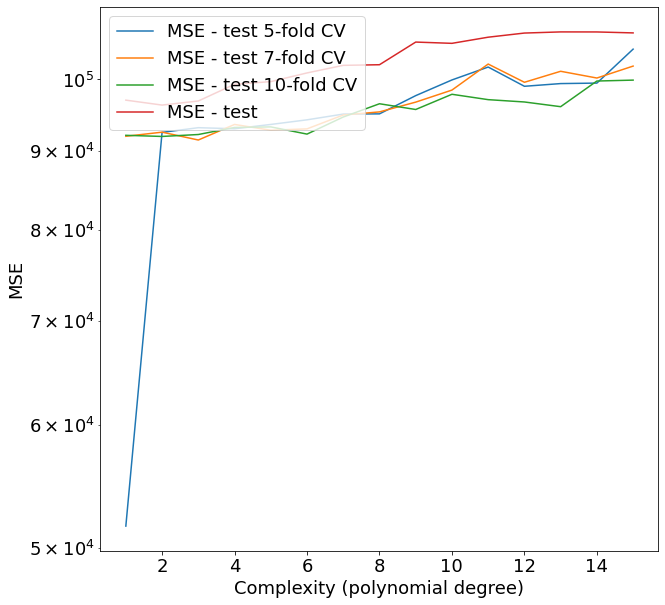

In [80]:
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) #not exactly sure if i need this...

max_degree = 15
folds = np.array([5,7,10], dtype=int) #number of folds

degree = np.linspace(1, max_degree, max_degree)

MSE_test = np.zeros(max_degree)
MSE_train = np.zeros(max_degree)
MSE_test_kfold = np.zeros(max_degree)

plt.figure(figsize=(figwidth, figheigth))

for k_folds in folds:
    
    MSE_test_kfold = np.zeros(max_degree)
    MSE_test_kfold_scikit = np.zeros(max_degree)
    
    for i in range(max_degree):
        X = create_X(x_values,y_values,int(degree[i]))
        MSE_test_kfold[i] = kfold_crossValidation(ols, X, z, k_folds)[0]
 
    plt.plot(degree, MSE_test_kfold, label='MSE - test %.i-fold CV'%k_folds)

for i in range(max_degree):
    X = create_X(x_values,y_values,int(degree[i]))
  
    np.random.seed(seed)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, shuffle=True, random_state=11)

    X_train, X_test = scaleData(X_train, X_test)
    z_predict, z_tilde, beta_ols = ols(X_test, X_train, z_test, z_train)

    MSE_train[i] = MSE(z_train,z_tilde)
    MSE_test[i] = MSE(z_test,z_predict)
    
    

plt.ylabel('MSE', fontsize=fontsize)
plt.xlabel('Complexity (polynomial degree)', fontsize=fontsize)
plt.plot(degree, MSE_test, label='MSE - test')
plt.yscale('log')
plt.tick_params(axis='both', which='both', labelsize=18)
plt.legend(fontsize=18, loc='upper left')
plt.savefig('figures/mse_test_kfold_realdata')
plt.show()

Real data Ridge and Lasso analysis

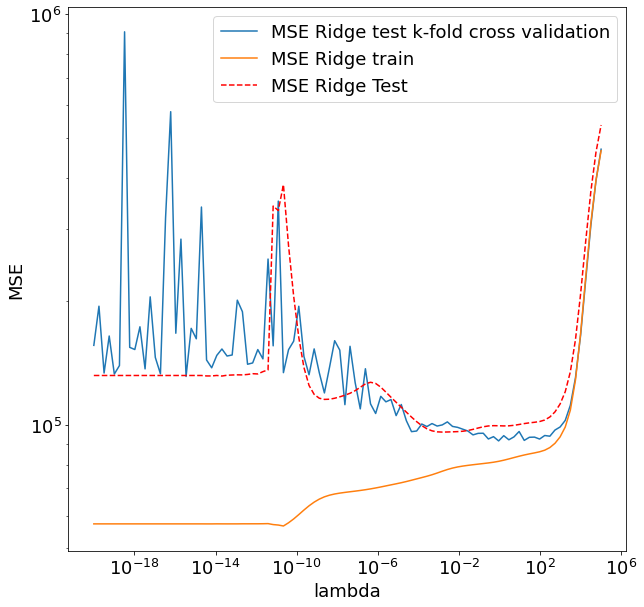

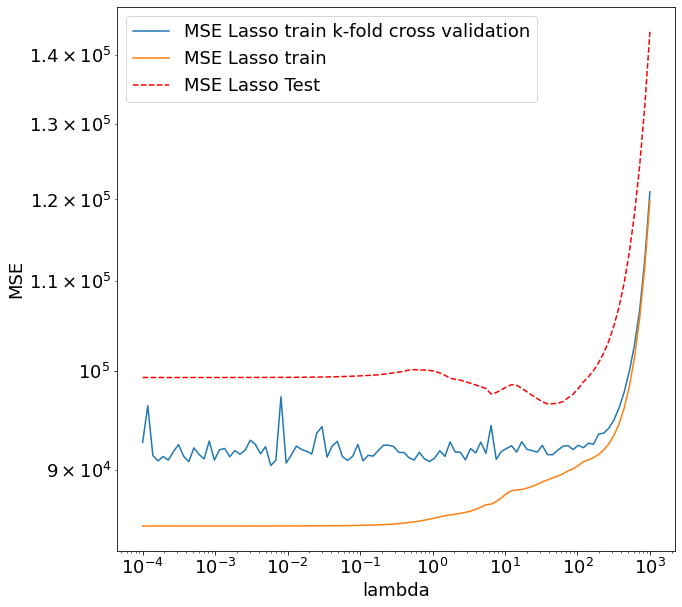

In [59]:
polydegree=15
X = create_X(x_values, y_values, polydegree)


nlambdas = 100
lambdas_ridge = np.logspace(-20, 5, nlambdas)
lambdas_lasso = np.logspace(-4, 3, nlambdas)


#split data
np.random.seed(seed)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, shuffle=True, random_state=11)

X_train, X_test = scaleData(X_train, X_test)

MSE_test_ridge = np.zeros(nlambdas)
MSE_train_ridge = np.zeros(nlambdas)
MSE_test_ridge_kfold = np.zeros(nlambdas)

MSE_test_lasso = np.zeros(nlambdas)
MSE_train_lasso = np.zeros(nlambdas)
MSE_test_lasso_kfold = np.zeros(nlambdas)

for i in range(nlambdas):
    _lambda = lambdas_ridge[i]
    
    #perform Ridge regression with k-fold cross validation
    z_predict, z_tilde, beta_ridge = ridge(X_test, X_train, z_test, z_train, _lambda)
    
    MSE_train_ridge[i] = MSE(z_train, z_tilde)
    MSE_test_ridge[i] = MSE(z_test, z_predict)
    
    MSE_test_ridge_kfold[i] = kfold_crossValidation(ridge, X, z, k_folds=7, _lambda=_lambda)[0]
    
    _lambda = lambdas_lasso[i]
    #perform Lasso regression with k-fold cross validation
    
    z_predict, z_tilde, beta_lasso = lasso(X_test, X_train, z_test, z_train, _lambda, tol=.085)
    
    MSE_train_lasso[i] = MSE(z_train, z_tilde)
    MSE_test_lasso[i] = MSE(z_test, z_predict)
    
    MSE_test_lasso_kfold[i] = kfold_crossValidation(lasso, X, z, k_folds=7, _lambda=_lambda, tol=.085)[0]
    
    
plt.figure(figsize=(figwidth, figheigth))
plt.tick_params(axis='both', which='both', labelsize=fontsize)
plt.plot(lambdas_ridge, MSE_test_ridge_kfold, label = 'MSE Ridge test k-fold cross validation')
plt.plot(lambdas_ridge, MSE_train_ridge, label = 'MSE Ridge train')
plt.plot(lambdas_ridge, MSE_test_ridge, 'r--', label = 'MSE Ridge Test')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lambda', fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.legend(fontsize=fontsize, loc='best')
plt.show()


plt.figure(figsize=(figwidth, figheigth))
plt.tick_params(axis='both', which='both', labelsize=fontsize)
plt.plot(lambdas_lasso, MSE_test_lasso_kfold, label = 'MSE Lasso train k-fold cross validation')
plt.plot(lambdas_lasso, MSE_train_lasso, label = 'MSE Lasso train')
plt.plot(lambdas_lasso, MSE_test_lasso, 'r--', label = 'MSE Lasso Test')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lambda', fontsize=fontsize)
plt.ylabel('MSE', fontsize=fontsize)
plt.legend(fontsize=fontsize, loc='best')
plt.show()

Make 3D-plot of the best MSE, based on complexity and lambda

In [144]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) #not exactly sure why i need this...

max_degree = 2
folds = np.array([5,7,10], dtype=int) #number of folds

degree = np.linspace(1, max_degree, max_degree)


nlambdas = 100
lambdas_ridge = np.logspace(-5, 5, nlambdas)
lambdas_lasso = np.logspace(-5, 5, nlambdas)


MSE_test_ridge = np.zeros((max_degree, nlambdas))
MSE_test_lasso = np.zeros((max_degree, nlambdas))

for j in range(max_degree):
    X = create_X(x_values,y_values, int(degree[j]))
    
    np.random.seed(seed)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, shuffle=True, random_state=11)
    X_train, X_test = scaleData(X_train, X_test)
    
    for i in range(nlambdas):
        _lambda = lambdas_ridge[i]
        
        z_predict, z_tilde = ridge(X_test, X_train, z_test, z_train, _lambda)
        MSE_test_ridge[j][i] = MSE(z_test, z_predict)

        _lambda = lambdas_lasso[i]
        
        z_predict, z_tilde = lasso(X_test, X_train, z_test, z_train, _lambda, tol=.085)
        MSE_test_lasso[j][i] = MSE(z_test, z_predict)

ValueError: too many values to unpack (expected 2)

In [ ]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
im = ax.imshow(MSE_test_ridge, cmap='hot')#, interpolation='nearest')
#im = ax.matshow(MSE_test_ridge, cmap=cm.gray_r)#, norm=LogNorm(vmin=0.01, vmax=1))
fig.colorbar(im)
plt.xlabel('Lambda')
plt.ylabel('Complexity')
#plt.xscale('log')
plt.show()


fig, ax = plt.subplots()
ax.imshow(MSE_test_lasso, cmap='hot', interpolation='nearest')
fig.colorbar(im)
plt.xlabel('Lambda')
plt.ylabel('Complexity')
#plt.xscale('log')
plt.show()

In [ ]:
def make_3D_plot(beta, degree, z_data):
    scaling_factor=step=5
    px = np.arange(0,z_data.shape[1],step,dtype=int)
    py = np.arange(0,z_data.shape[0],step,dtype=int)
    terrain_fit_OLS = np.zeros((len(py),len(px)))
    terrain_scaled = np.zeros((len(py),len(px)))
    lenpx = len(px)
    lenpy = len(py)
    px, py = np.meshgrid(px,py)
    px = px.ravel()
    py = py.ravel()
    X = create_X(px,py,degree)
    z = X @ beta
    for i in range(lenpx):
        for j in range(lenpy):
            terrain_fit_OLS[j,i]=z[i*lenpy+j]
            
    fig, (ax0, ax1) = plt.subplots(ncols=2,figsize=(9, 3))
    mapstyle="rainbow"
    #ax2.set_title("Original")
    #ax0.set_title("OLS degree %d"%(ideal_degree_OLS))
    im0=ax0.imshow(terrain_fit_OLS, cmap=mapstyle)#,vmin = 0, vmax = 2000)
    im1=ax1.imshow(z_data, cmap=mapstyle)#, vmin = 0, vmax = 2000)
    #cbar=plt.colorbar(im,ax=ax)
    #cbar.set_label("Height [m]")
    fig.colorbar(im0,ax=ax0)
    fig.colorbar(im1,ax=ax1)
    plt.show()